In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import ClusterMixin
from sklearn.base import BaseEstimator
from random import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
from tqdm import *

In [2]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 0 to 1206
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   race_year_id          1133 non-null   int64  
 1   event                 1133 non-null   object 
 2   race                  1133 non-null   object 
 3   country               1133 non-null   object 
 4   participation         1133 non-null   object 
 5   distance              1133 non-null   float64
 6   elevation_gain        1133 non-null   float64
 7   elevation_loss        1133 non-null   float64
 8   aid_stations          1133 non-null   int64  
 9   participants          1133 non-null   int64  
 10  country_code          1133 non-null   object 
 11  year                  1133 non-null   int64  
 12  month                 1133 non-null   int64  
 13  day                   1133 non-null   int64  
 14  frequency_in_ranking  1133 non-null   int64  
 15  equivalent_distance  

In [6]:
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.loc[join.speed < 20]
join = join.loc[join.distance > 150]

In [7]:
join_unique = join.drop_duplicates(subset=['runner_id'])

In [8]:
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)
# join = join.loc[join.speed > 30]
# join = join.loc[join.equivalent_speed > 30]

<AxesSubplot:xlabel='equivalent_distance', ylabel='Count'>

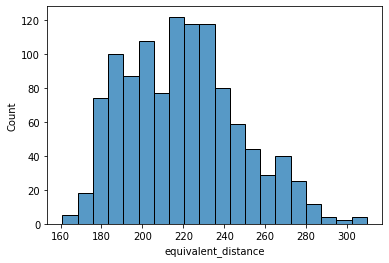

In [9]:
sns.histplot(
    x = race.equivalent_distance[race.distance > 150]
)

<AxesSubplot:xlabel='distance', ylabel='Count'>

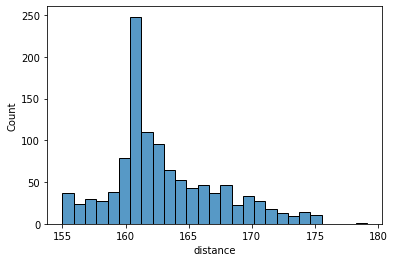

In [10]:
sns.histplot(
    x = race.distance[race.distance > 150]
)

<AxesSubplot:xlabel='equivalent_distance', ylabel='Count'>

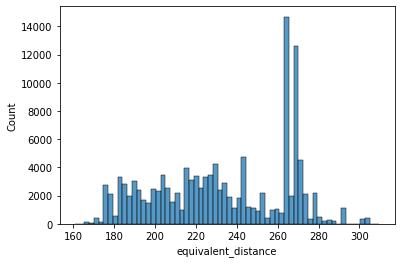

In [11]:
sns.histplot(
    x = join.equivalent_distance[join.equivalent_distance > 150]
)

<AxesSubplot:xlabel='weighted_elevation', ylabel='Count'>

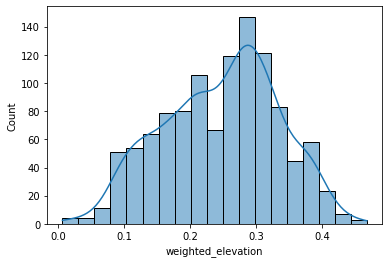

In [12]:
sns.histplot(
    x = race.weighted_elevation[race.distance > 150],
    kde = True
)

<AxesSubplot:xlabel='weighted_elevation', ylabel='equivalent_distance'>

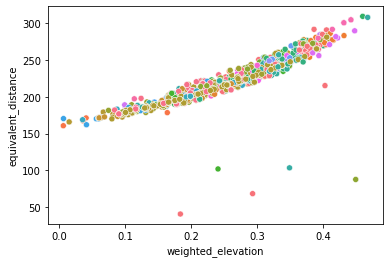

In [13]:
sns.scatterplot(
    x = "weighted_elevation",
    y = "equivalent_distance",
    data = race,
    hue = "country",
    legend = False
)

<AxesSubplot:xlabel='distance', ylabel='equivalent_distance'>

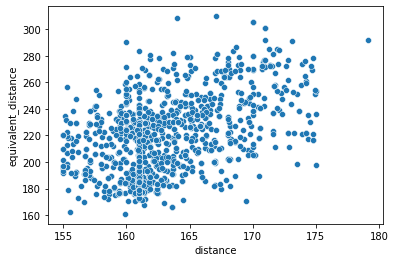

In [14]:
sns.scatterplot(
    x = "distance",
    y = "equivalent_distance",
    data = race[race.distance > 150]
    
)

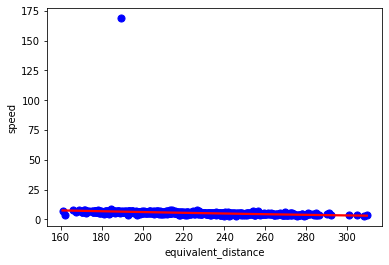

In [15]:
ax = sns.regplot(
    x = "equivalent_distance",
    y = "speed",
    data = join[join.distance > 150],
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    x_estimator=np.mean,
    order = 2
)

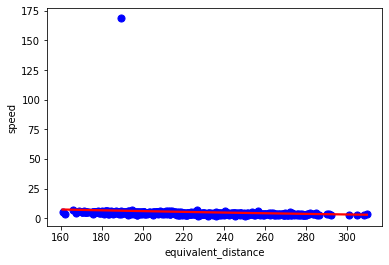

In [16]:
ax = sns.regplot(
    x = "equivalent_distance",
    y = "speed",
    data = join[join.distance > 150],
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    x_estimator=np.min,
    order = 2
)

<AxesSubplot:>

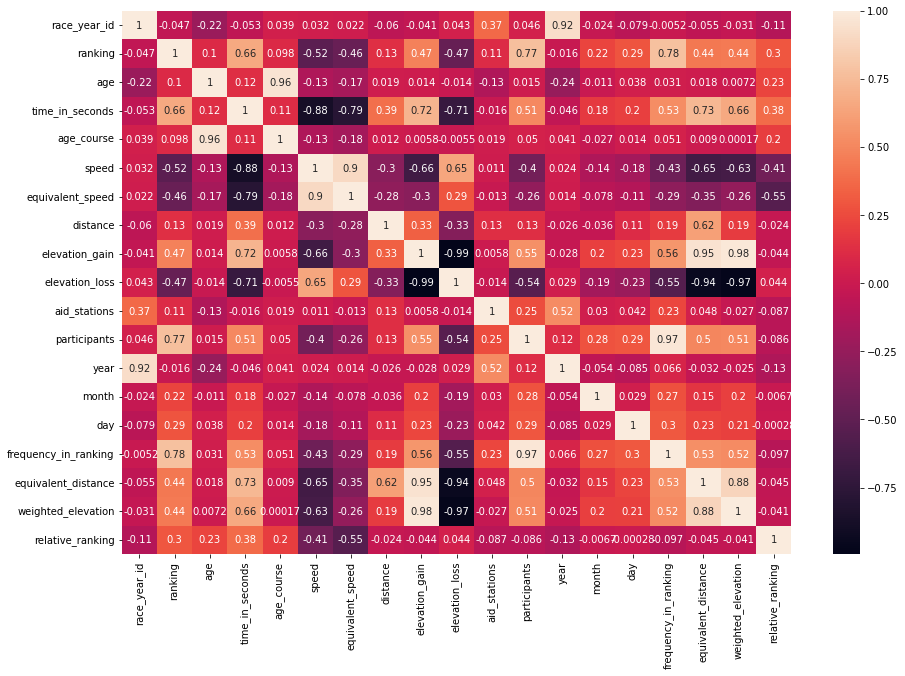

In [17]:
plt.figure(figsize=(15,10))
sns.heatmap(join.corr(), annot = True)

In [18]:
def homeCountry(df, th):
    '''
        :param df: join, merge de runners avec races
        :param th: threshold, nombre de courses minimales effectuées par les coureurs
    '''
    runners_occ = df['runner_id'].value_counts().fillna(0).astype(int)
    runners_occ = pd.DataFrame(runners_occ).reset_index()
    runners_occ = runners_occ.rename( columns= {'index':'runner_id','runner_id':'occ'})
    
    pro_runners_id = runners_occ.loc[runners_occ.occ >= th]
    
    res = pd.DataFrame()
    
    for runner in tqdm(pro_runners_id.runner_id):
        runner_info = df.loc[(df.runner_id == runner)]
        
        res = res.append({'runner_id': runner,
                         'nationality': runner_info['nationality'].iloc[0],
                         'total_races': runner_info.shape[0],
                         'home_races': runner_info.loc[runner_info.country == runner_info['nationality']].shape[0],
                         'fore_races': runner_info.loc[runner_info.country != runner_info['nationality']].shape[0]
                       }, ignore_index = True)
    
    
    
    
    res = res.assign(
        perc_home = res.home_races / res.total_races * 100
    )
    return res

In [19]:
res = homeCountry(join, 5)

100%|██████████████████████████████████████| 3773/3773 [00:35<00:00, 105.28it/s]


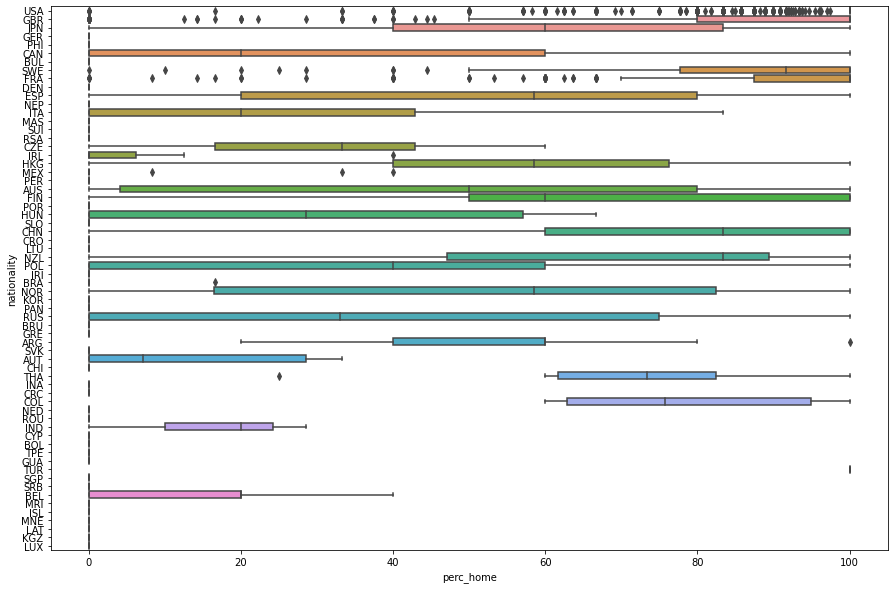

In [20]:
plt.figure(figsize=(15,10))
sns.boxplot(
    x = "perc_home",
    y = "nationality",
    data = res
)
plt.savefig('percentage_home.pdf')

In [21]:
def homeRace(df):
    '''
        :param df: join, merge de runners avec races
    '''
    res = pd.DataFrame()
    
    for race in tqdm(df.race_year_id.unique()):
        runners_in_race = df.loc[(df.race_year_id == race)]
        
        res = res.append({'race_year_id': race,
                          'total_runners': runners_in_race.shape[0],
                          'home_runners': runners_in_race.loc[runners_in_race.nationality == runners_in_race['country']].shape[0],
                          'fore_runners': runners_in_race.loc[runners_in_race.nationality != runners_in_race['country']].shape[0]
                       }, ignore_index = True)
    
    
    
    
    res = res.assign(
        perc_home = res.home_runners / res.total_runners * 100,
        perc_fore = res.fore_runners / res.total_runners * 100
    )
    return res

In [22]:
res2 = homeRace(join)

100%|██████████████████████████████████████| 1133/1133 [00:02<00:00, 445.93it/s]


In [23]:
new_race = pd.merge(race, res2, left_on="race_year_id", right_on="race_year_id", how="left")
new_race = new_race.dropna()

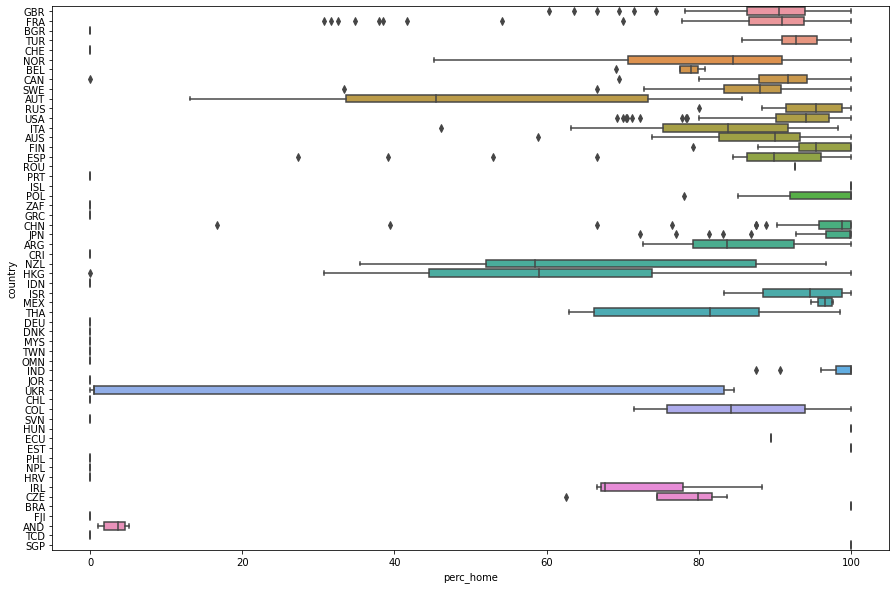

In [24]:
plt.figure(figsize=(15,10))
sns.boxplot(
    x = "perc_home",
    y = "country",
    data = new_race
)
plt.savefig('percentage_home_race.pdf')

<AxesSubplot:xlabel='year', ylabel='perc_fore'>

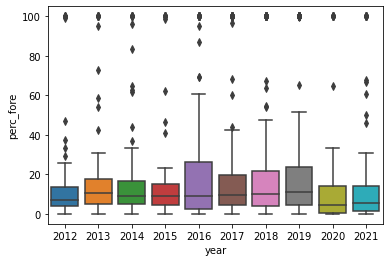

In [25]:
sns.boxplot(
    y = 'perc_fore',
    x = 'year',
    data = new_race
)


### Pourcentage d'étrangers moyens par course

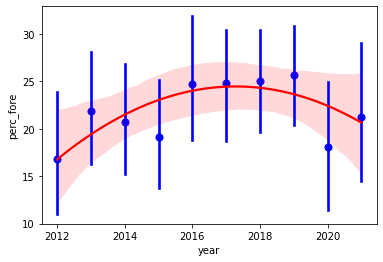

In [26]:
ax = sns.regplot(
    x = "year",
    y = "perc_fore",
    data = new_race,
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    x_estimator=np.mean,
    order = 2
)

<AxesSubplot:xlabel='country', ylabel='count'>

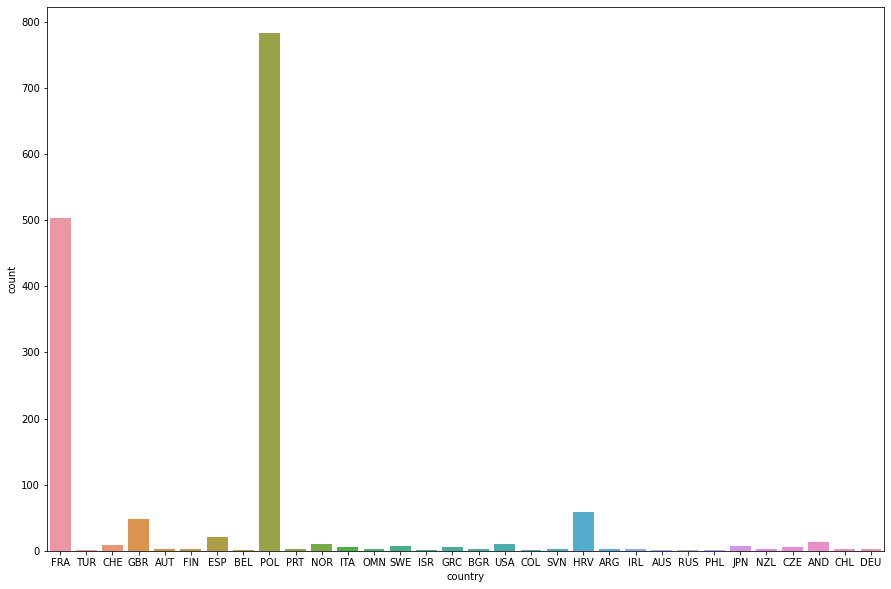

In [27]:
plt.figure(figsize=(15,10))

sns.countplot(
    x = 'country',
    data = join.loc[join.nationality == "POL"]
)

<AxesSubplot:xlabel='perc_fore', ylabel='country'>

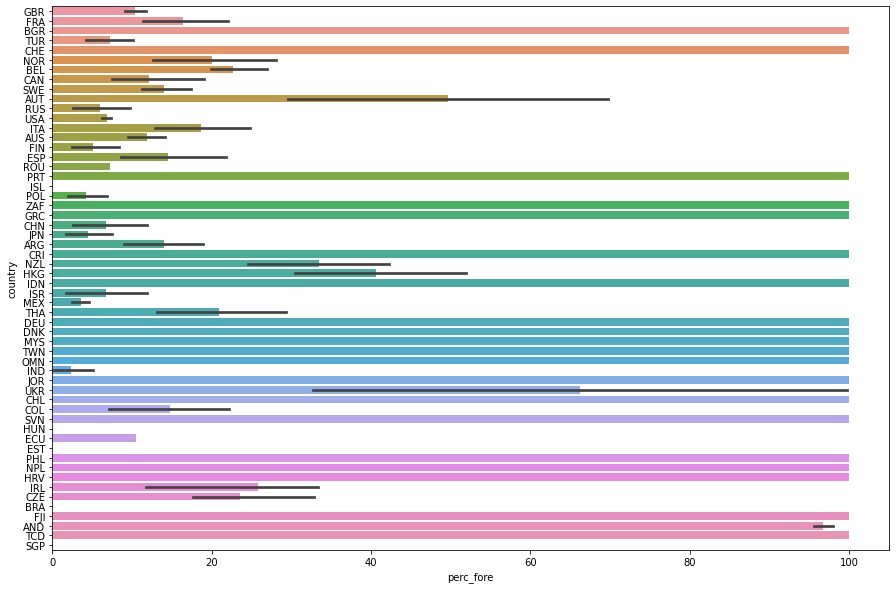

In [28]:
plt.figure(figsize=(15,10))
sns.barplot(
    x = "perc_fore",
    y = "country",
    data = new_race
)

In [29]:
new_race[new_race.country == "FRA"].sort_values('perc_fore')

,race_year_id,event,race,country,participation,distance,elevation_gain,elevation_loss,aid_stations,participants,...,day,frequency_in_ranking,equivalent_distance,weighted_elevation,date,total_runners,home_runners,fore_runners,perc_home,perc_fore
724,10563,GRAND TRAIL STEVENSON,GTS 3 jours - B,FRA,solo,156.20,5143.0,-5986.0,6,23,...,15,23,207.63,0.247700,2016-07-15,23.0,23.0,0.0,100.000000,0.000000
137,50051,Infinity Trail Backyard - Normandie,Infinity Trail - 23 boucles,FRA,solo,155.30,5160.0,-5160.0,1,80,...,31,2,206.90,0.249396,2020-07-31,2.0,2.0,0.0,100.000000,0.000000
160,53283,LE DERNIER HOMME DEBOUT MORVAN,24 Boucles,FRA,solo,169.90,5740.0,-5740.0,1,350,...,25,6,227.30,0.252530,2020-01-25,6.0,6.0,0.0,100.000000,0.000000
500,31523,Les Traces du Nord Basse-Terre,L'Ultra-Trail®,FRA,solo,155.40,6290.0,-6300.0,14,400,...,16,10,218.30,0.288136,2018-02-16,10.0,10.0,0.0,100.000000,0.000000
1070,2871,Le Grand Raid De La Réunion,Le Grand Raid De La Réunion,FRA,solo,168.90,10982.0,-10952.0,0,1363,...,18,1363,278.72,0.394015,2012-10-18,1208.0,1167.0,41.0,96.605960,3.394040
2,69855,Grand Raid des Pyrénées,Ultra Tour 160,FRA,solo,167.00,9980.0,-9980.0,13,600,...,20,455,266.80,0.374063,2021-08-20,455.0,435.0,20.0,95.604396,4.395604
20,68776,Ultra Tour des 4 Massifs,Ut4M 160 Xtrem,FRA,solo,179.10,11290.0,-11350.0,17,473,...,16,473,292.00,0.386644,2021-07-16,473.0,452.0,21.0,95.560254,4.439746
108,54013,SPARNATRAIL,P'tiot Sparnatrail,FRA,solo,33.30,750.0,-750.0,1,1800,...,10,693,40.80,0.183824,2019-11-10,693.0,661.0,32.0,95.382395,4.617605
26,71066,ULTRA 01,Ultra 01 170 KM,FRA,solo,174.90,7590.0,-7590.0,15,500,...,9,127,250.80,0.302632,2021-07-09,127.0,121.0,6.0,95.275591,4.724409
987,4870,Le Grand Raid De La Réunion,Le Grand Raid De La Réunion,FRA,solo,164.60,10100.0,-10060.0,0,1363,...,17,1363,265.60,0.380271,2013-10-17,1271.0,1205.0,66.0,94.807238,5.192762


In [30]:
new_race.loc[new_race.race_year_id == 11263]['year']

707    2016
Name: year, dtype: int64

In [31]:
French = join.loc[join.nationality == "FRA"]
runners_occ = French['runner_id'].value_counts().fillna(0).astype(int)
runners_occ = pd.DataFrame(runners_occ).reset_index()
runners_occ = runners_occ.rename( columns= {'index':'runner_id','runner_id':'occ'})


pro_runners_id = runners_occ.loc[runners_occ.occ >= 10]
pro_runners_id

,runner_id,occ
0,JOUFFROYRomainFRAM43.0,16
1,GUILLONAntoineFRAM51.0,15
2,BALAHACHIRafionFRAM41.0,14
3,FRANCOISMatthiasFRAM44.0,12
4,BETOURETSebastienFRAM44.0,12
5,LELEVETCyrilFRAM50.0,11
6,BLANCHETJulietteFRAW42.0,11
7,DELIKATPatrickFRAM53.0,11
8,PAYENCharlesFRAM35.0,11
9,ROUANETRenaudFRAM43.0,10


<AxesSubplot:xlabel='country', ylabel='count'>

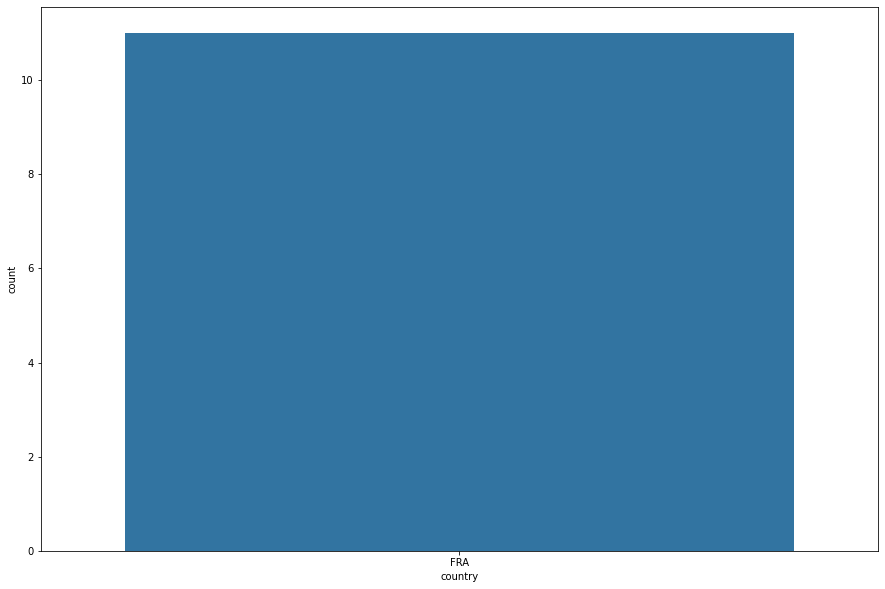

In [32]:
plt.figure(figsize=(15,10))

sns.countplot(
    x = 'country',
    data = join.loc[join.runner_id == 'LELEVETCyrilFRAM50.0']
)

In [33]:
count = 0
total_races = len(race)
for r in new_race.race_year_id.unique():
    country = join.loc[join.race_year_id == r].iloc[0].country
    nat_first_df = join.loc[(join.race_year_id == r) & (join.ranking == 1)]
    if nat_first_df.shape[0] > 0:
        if country == nat_first_df.iloc[0]['nationality']:
            count += 1
    
print(f"{total_races=}")
print(f"{count=}")      

total_races=1133
count=845


In [34]:
def get_first_place_local_rate(join,new_race, pas):

    race_fore_decils = []
    race_perc_foreigners = []
    for i in np.arange(2 * pas,10, pas):
        race_fore_decils.append(new_race.loc[new_race.perc_fore >= i/10])
        race_perc_foreigners.append(i*10)
        
    perc_first_at_home = []
    for d in tqdm(race_fore_decils):
        count = 0
        total_races = len(d)
        for r in d.race_year_id.unique():
            country = join.loc[join.race_year_id == r].iloc[0].country
            nat_first_df = join.loc[(join.race_year_id == r) & (join.ranking == 1)]
            if nat_first_df.shape[0] > 0:
                if country == nat_first_df.iloc[0]['nationality']:
                    count += 1

        perc_first_at_home.append(count / total_races * 100)

    df = pd.DataFrame({'race_perc_foreigner': race_perc_foreigners, 'perc_first_local': perc_first_at_home})

    return df

In [35]:
df = get_first_place_local_rate(join,new_race, 0.1)

100%|███████████████████████████████████████████| 98/98 [02:06<00:00,  1.29s/it]


<AxesSubplot:xlabel='race_perc_foreigner', ylabel='perc_first_local'>

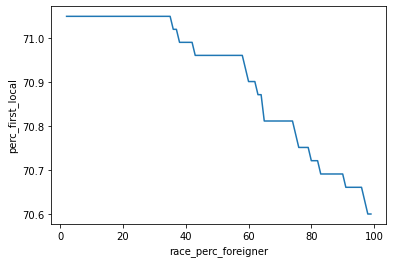

In [36]:
sns.lineplot(
    x = "race_perc_foreigner",
    y = "perc_first_local",
    data = df
)

<AxesSubplot:xlabel='perc_fore'>

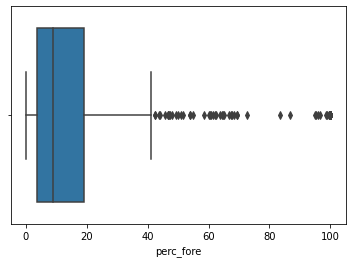

In [37]:
sns.boxplot(x = new_race.perc_fore)

In [38]:
def get_ranking_local_rate(join,new_race, max_relative_ranking = 1):
        
    new_race = new_race.loc[(new_race.perc_fore > 0) & (new_race.perc_fore < 100)]
    avg_local_runners_ranking_list = []
    avg_foreign_runners_ranking_list = []
    race_year_id_list = new_race.race_year_id.unique()
    for r in new_race.race_year_id.unique():
            ra = join.loc[(join.race_year_id == r)]
            country = ra.loc[ra.race_year_id == r].iloc[0].country
            avg_local_runners_ranking = ra.loc[(ra.nationality == country) & (ra.relative_ranking <= max_relative_ranking)].relative_ranking.mean()
            avg_foreign_runners_ranking = ra.loc[(ra.nationality != country) & (ra.relative_ranking <= max_relative_ranking)].relative_ranking.mean()

            avg_local_runners_ranking_list.append(avg_local_runners_ranking)
            avg_foreign_runners_ranking_list.append(avg_foreign_runners_ranking)
            race_perc_foreigner = new_race.perc_fore

    df = pd.DataFrame({'race_year_id': race_year_id_list,
                       'race_perc_foreigner': race_perc_foreigner,
                       'avg_local_runners_ranking': avg_local_runners_ranking_list,
                       'avg_foreign_runners_ranking': avg_foreign_runners_ranking_list
                      })

    return df.fillna(0)

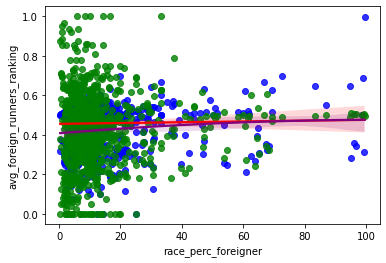

In [39]:
cdf = get_ranking_local_rate(join,new_race)
ax = sns.regplot(
    x = 'race_perc_foreigner',
    y = 'avg_local_runners_ranking',
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    data = cdf
)
ax = sns.regplot(
    x = 'race_perc_foreigner',
    y = 'avg_foreign_runners_ranking',
    scatter_kws={"color": "green"}, line_kws={"color": "purple"},
    data = cdf,
    order = 2
)

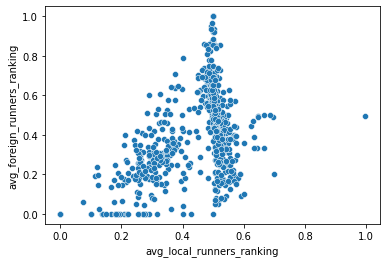

In [40]:
ax = sns.scatterplot(
    x = 'avg_local_runners_ranking',
    y = 'avg_foreign_runners_ranking',
    data = cdf,
    
)

In [41]:
join_cdf =  pd.merge(cdf, new_race, left_on="race_year_id", right_on="race_year_id", how="left")
join_cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836 entries, 0 to 835
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   race_year_id                 836 non-null    int64         
 1   race_perc_foreigner          836 non-null    float64       
 2   avg_local_runners_ranking    836 non-null    float64       
 3   avg_foreign_runners_ranking  836 non-null    float64       
 4   event                        836 non-null    object        
 5   race                         836 non-null    object        
 6   country                      836 non-null    object        
 7   participation                836 non-null    object        
 8   distance                     836 non-null    float64       
 9   elevation_gain               836 non-null    float64       
 10  elevation_loss               836 non-null    float64       
 11  aid_stations                 836 non-null    

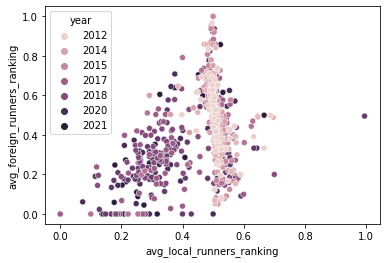

In [42]:
ax = sns.scatterplot(
    x = 'avg_local_runners_ranking',
    y = 'avg_foreign_runners_ranking',
    hue = "year",
    data = join_cdf
)

<AxesSubplot:>

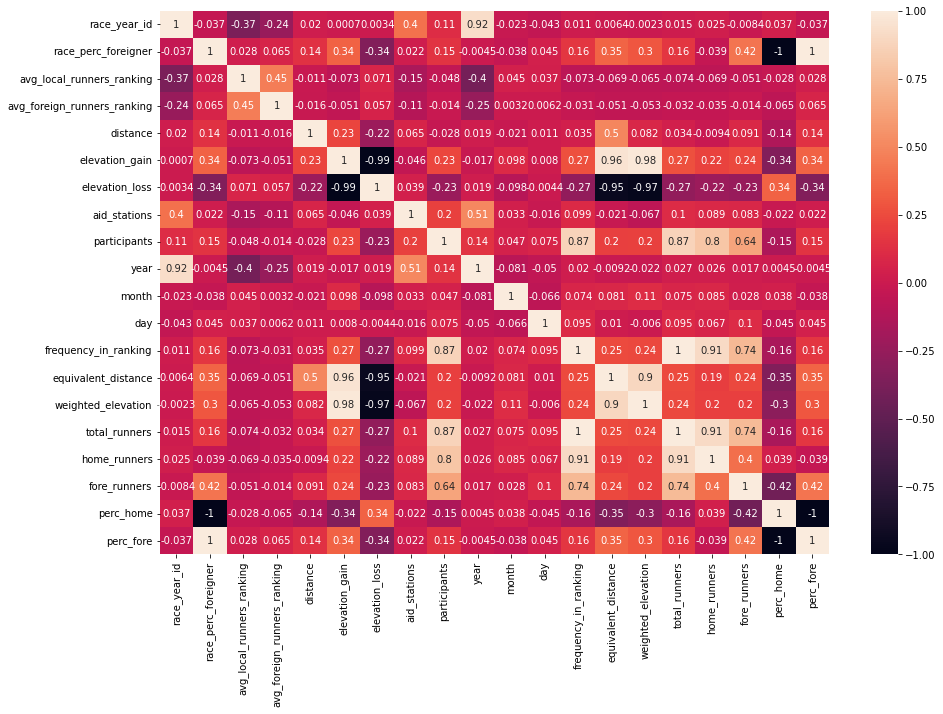

In [43]:
plt.figure(figsize=(15,10))
sns.heatmap(join_cdf.corr(), annot = True)

In [44]:
join_of_doom = pd.merge(join_cdf, runner, left_on="race_year_id", right_on="race_year_id", how="left")

<AxesSubplot:>

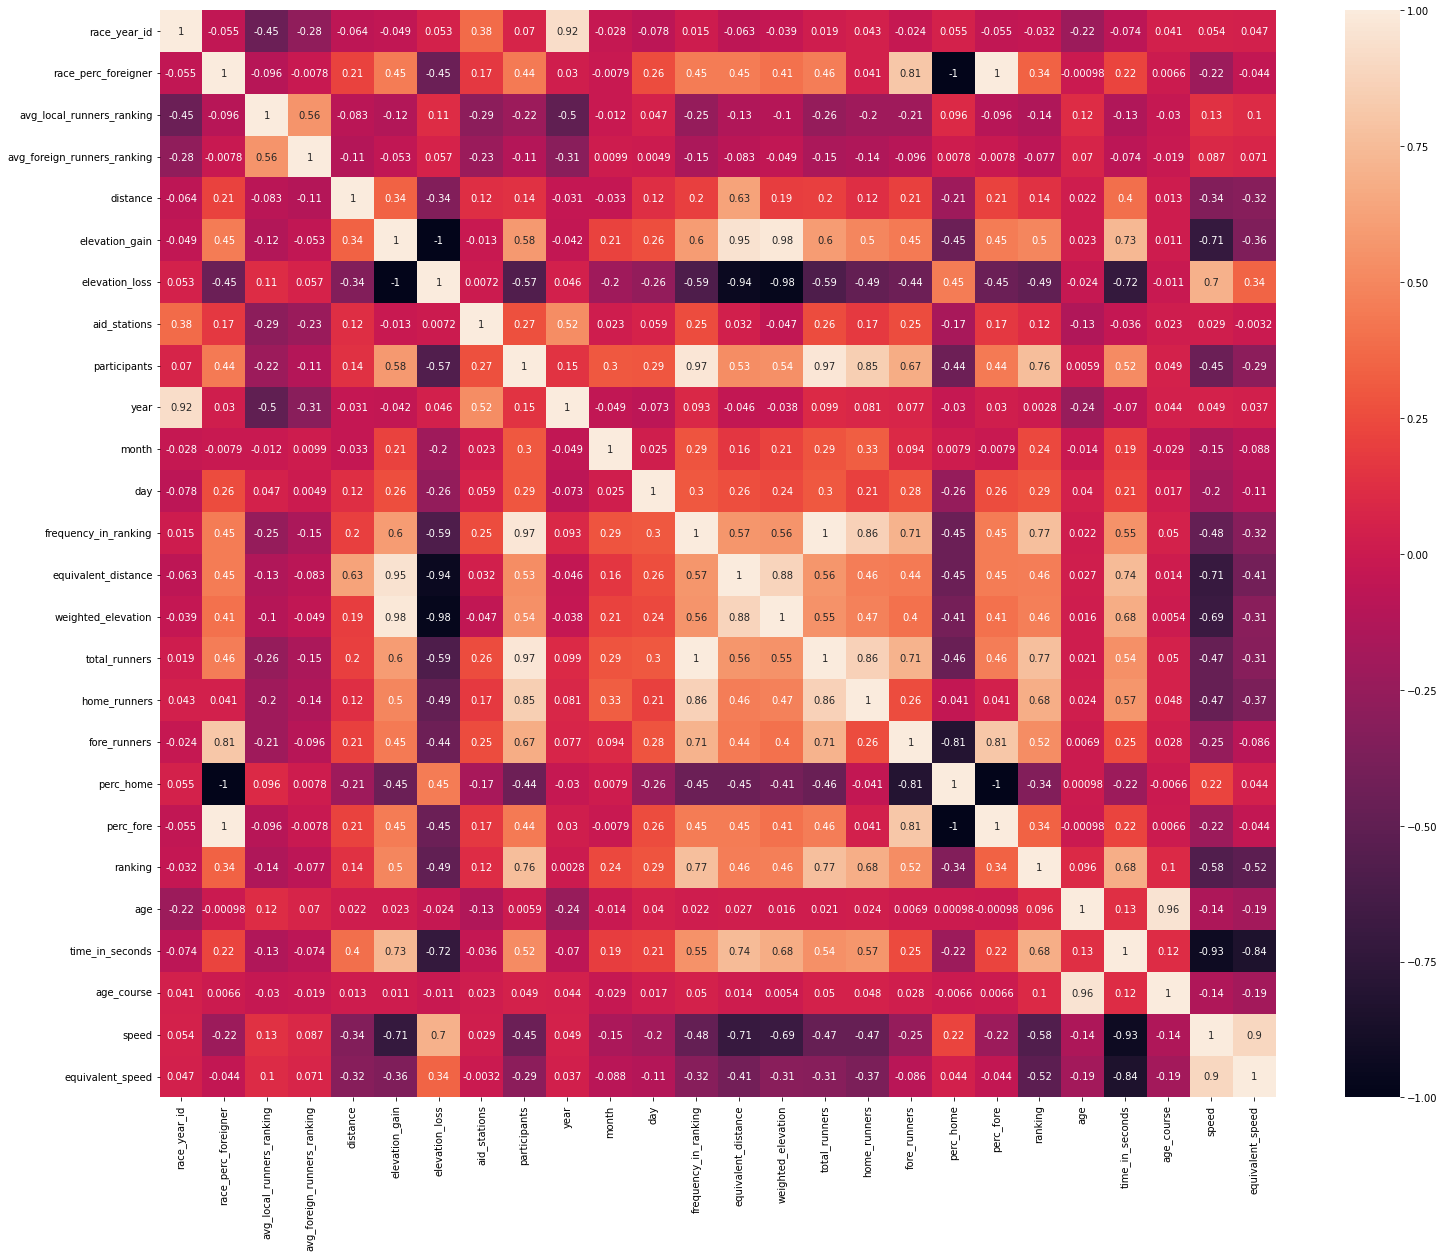

In [45]:
plt.figure(figsize=(25,20))
sns.heatmap(join_of_doom.corr(), annot = True)